In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
import cv2
from skimage.draw import polygon2mask
from skimage.measure import find_contours
import pywt

In [ ]:
def movie_path(mouse, date, file):
    """Returns the file path for a given movie recording."""
    return "N:/GEVI_Wave/Analysis/Visual/" + mouse + "/20" + str(date) + "/" + file + '/cG_unmixed_dFF.h5'

def mask_region(movie, raw_outlines, binning, spaceorigin, region, plot=False):
    # Define the corresponding outline indices for the selected brain region
    indices=[37]
    spaceorigin = (spaceorigin - 1) / binning + 1  # Apply space origin transformation

    # Extract all outlines and scale them according to binning
    outlines_nums = np.arange(raw_outlines.shape[2]) 
    outlines = raw_outlines[:, :, outlines_nums] / binning

    outlines[:, 0, :] -= spaceorigin[1] - 1  # Adjust Y-coordinates
    outlines[:, 1, :] -= spaceorigin[0] - 1  # Adjust X-coordinates

    # Define the movie dimensions
    movie_shape = movie.shape[1:3]  # (height, width)
            
    if plot:
    # Plot the first movie frame
        plt.figure(figsize=(6, 6))
        plt.imshow(movie[0])  # Display movie frame
        plt.title(f"Movie with {region} Outline")

    total_mask = np.zeros(movie_shape, dtype=bool)

    for i in indices:
        # Extract the ROI outline
        outline = outlines[i, :, :]  # Shape (2, N)

        valid_indices = ~np.isnan(outline).any(axis=0)  # Find non-NaN indices
        x_coords = outline[1, valid_indices]
        y_coords = outline[0, valid_indices]

        # Create a mask using polygon2mask
        roi_mask = polygon2mask(movie_shape, np.column_stack((y_coords, x_coords)))
        roi_mask = np.flipud(roi_mask).astype(bool)
        total_mask |= roi_mask  # Any pixel belonging to at least one ROI remains unmasked

    # Apply mask to the movie
    movie_roi = movie * total_mask  # Broadcasting applies the mask to all frames

    # Find contours of the ROI mask
    contours = find_contours(total_mask, level=0.5)  # Extract the outline

    if plot:
        # Overlay the mask outline
        for contour in contours:
            plt.plot(contour[:, 1], contour[:, 0], color='red', linewidth=1.5)  # Plot contour in red
    plt.show()

    return movie_roi

def load_and_mask(path_movie):
    """
    Loads a movie file, applies masking, and optionally extracts a specific brain region.

    Args:
    - mouse (str): Mouse identifier.
    - date (str or int): Experiment date in YYMMDD format.
    - file (str): Recording file identifier.
    - region (str, optional): Brain region to isolate ('V1' or 'SSC'). If None, the full movie is returned.

    Returns:
    - movie (numpy.ndarray): 3D array (t, x, y) representing the processed movie.
    - fps (float): Frames per second of the movie.
    """

    with h5py.File(path_movie, 'r') as mov_file:
        specs = mov_file["specs"]
        mov = mov_file['mov'][()][:2, :, :]
        binning = specs["binning"][()].squeeze()  
        raw_outlines = specs["extra_specs"]["allenMapEdgeOutline"][()].squeeze()  
        spaceorigin = specs["spaceorigin"][()].squeeze()  

    # Replace NaN values in the movie
    movie = np.nan_to_num(mov)
    movie = np.flip(movie, axis=1)

    # If a specific brain region is provided, apply the corresponding region mask
    movie = mask_region(movie, raw_outlines, binning, spaceorigin, 'V1', plot=True)

    return movie

In [6]:
mouse = 'cfm002'
trial_info_path = 'trial_info/TrialInfo_cfm002mjr.csv'

df = pd.read_csv(trial_info_path)
unique_recordings = df[['AnimalCode', 'File', 'Date']].drop_duplicates() # Identify unique recordings
print(f"Found {len(unique_recordings)} recordings")


Found 20 recordings


240510/meas00


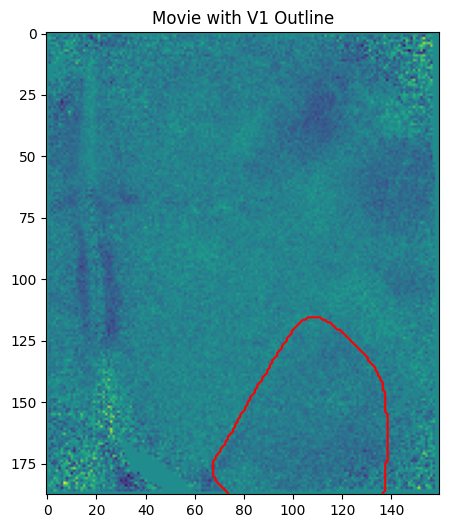

240510/meas01


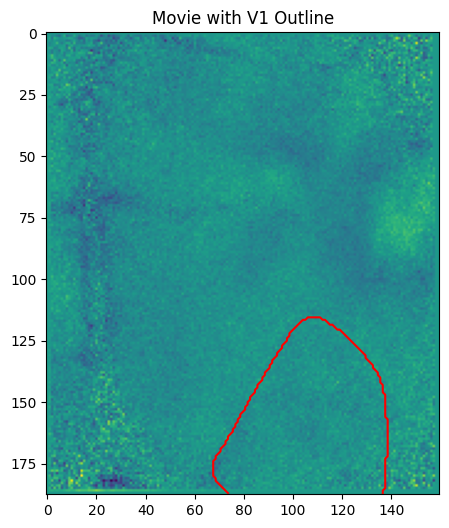

240510/meas02


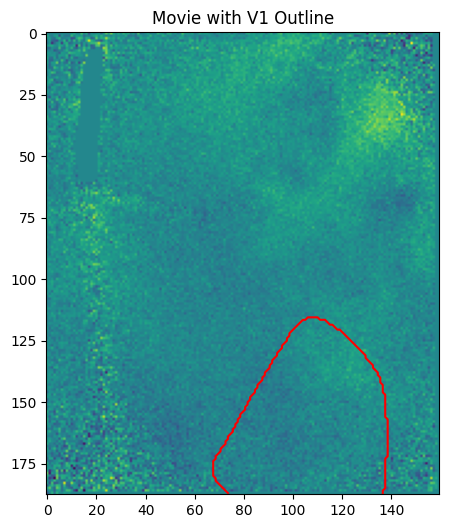

240513/meas00


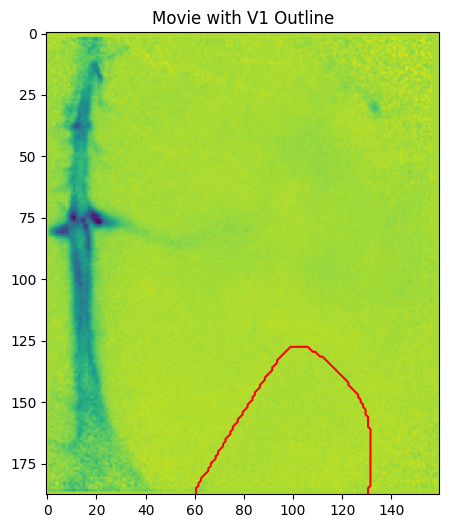

240513/meas01


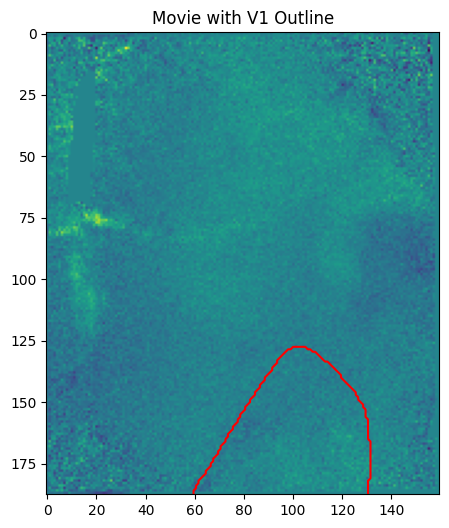

240514/meas00


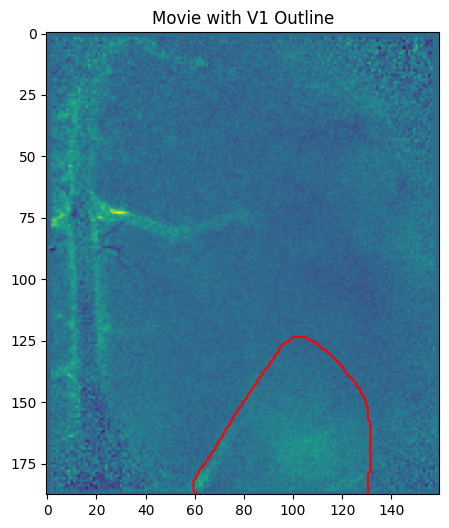

240514/meas01


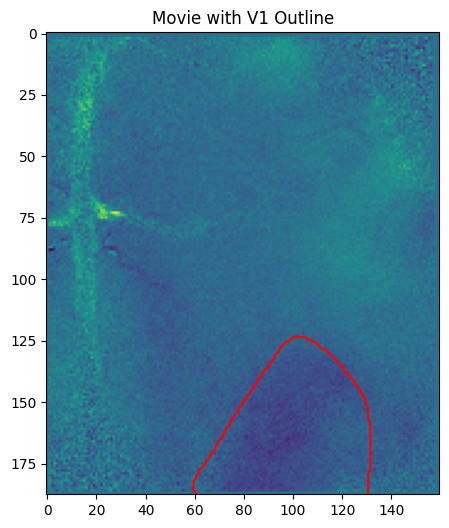

240515/meas00


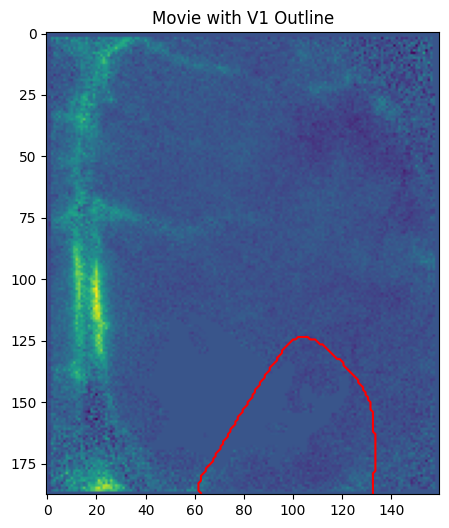

240515/meas01


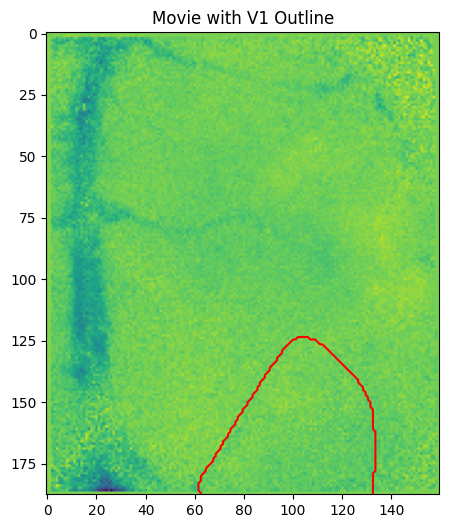

240516/meas00


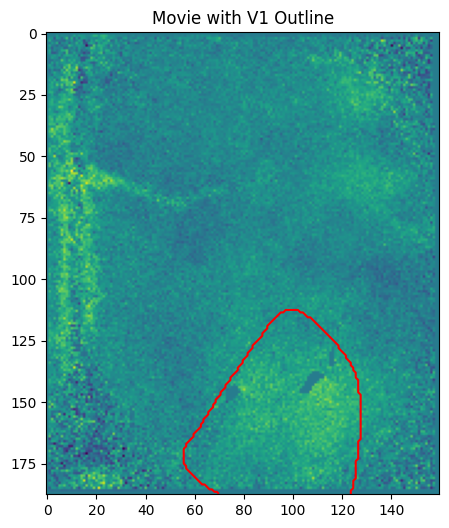

240516/meas01


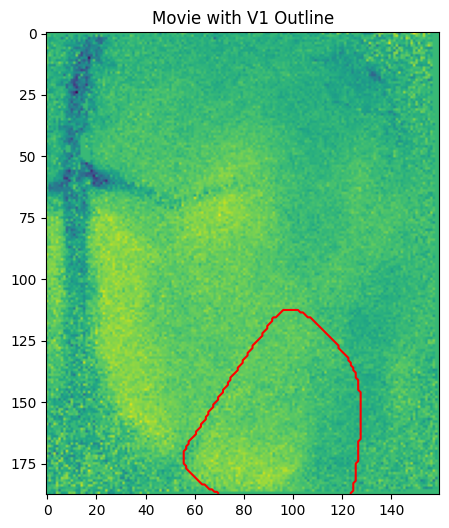

240516/meas02


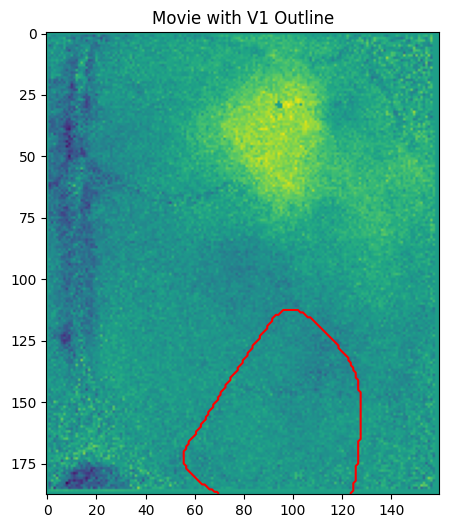

240517/meas00


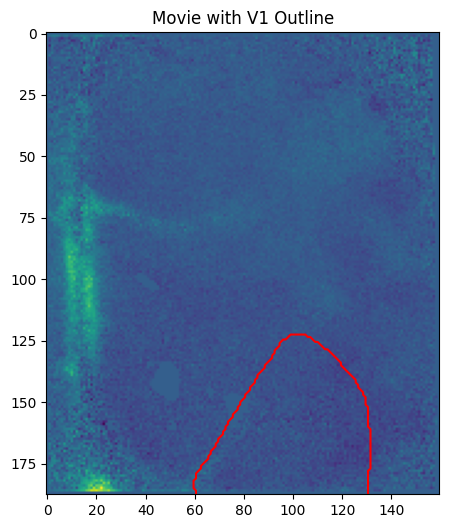

240517/meas01


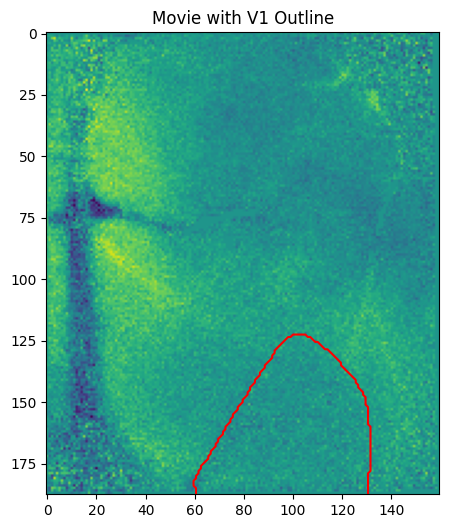

240517/meas02


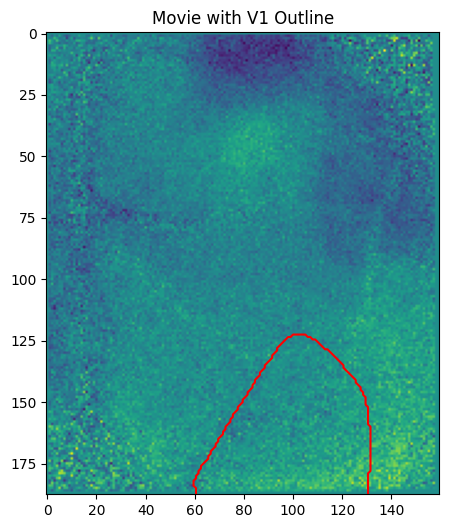

240518/meas00


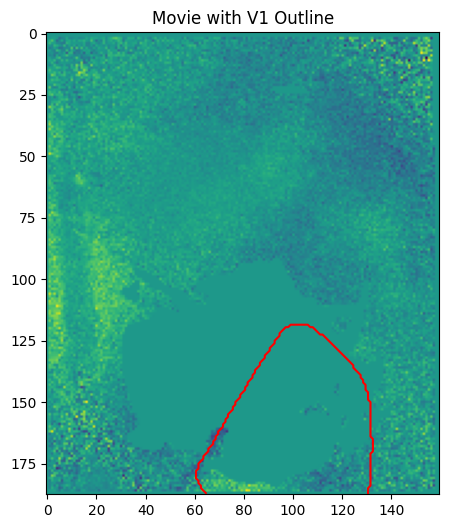

240518/meas01


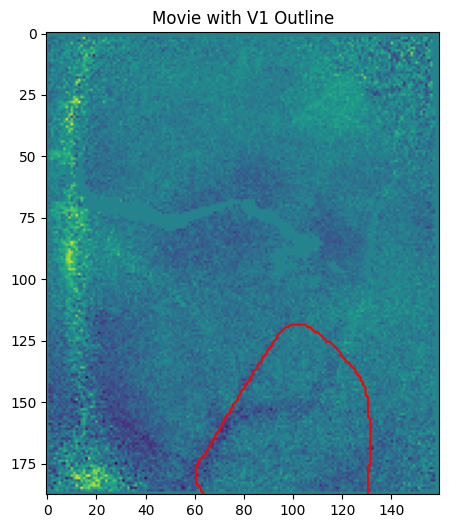

240519/meas00


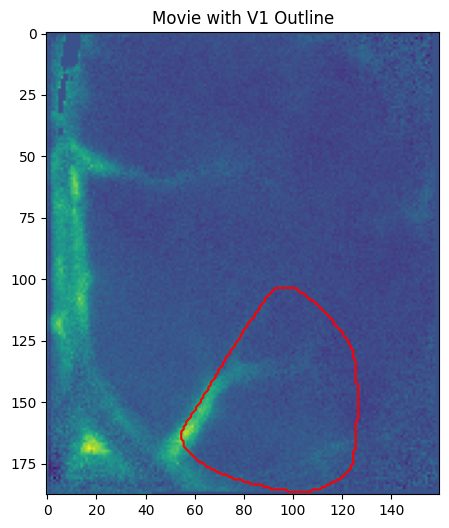

240519/meas01


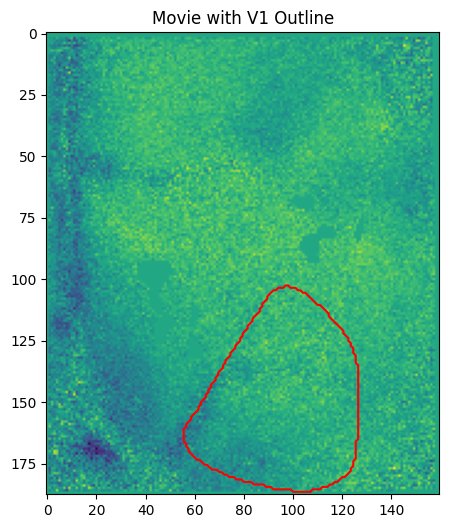

240519/meas02


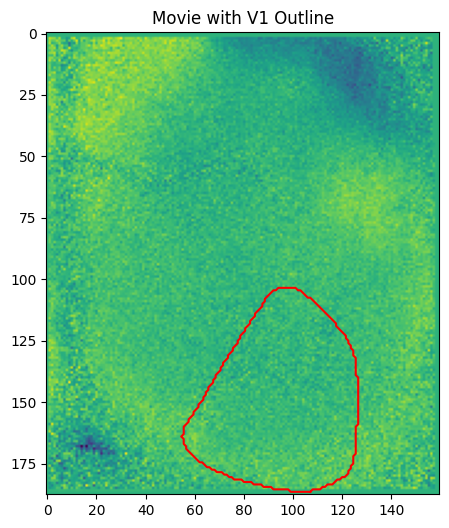

In [7]:
# Load and process movies for each unique recording
for _, row in unique_recordings.iterrows():
    mouse = row['AnimalCode']
    date = row['Date']
    file = row['File']
    print(f"{date}/{file}")
    path = movie_path(mouse, date, file)
    movie = load_and_mask(path)